In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', None)
pd.set_option('future.no_silent_downcasting', True)
sns.set()

df = pd.read_csv('data_part_2.csv')

print(df.shape)
df.head()

(1009, 18)


,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,final_price,time_of_day,sold
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,night,1
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,NaN,morning,0
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,NaN,night,0
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,NaN,evening,0
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,NaN,day,0


# Set Proper Data Types

In [2]:
dtype_mapping = {
    'user_id': 'int64', 
    'region': 'object', 
    'device': 'object', 
    'channel': 'object', 
    'session_start': 'datetime64[ns]', 
    'session_end': 'datetime64[ns]', 
    'sessiondurationsec': 'float64', 
    'session_date': 'datetime64[ns]', 
    'month': 'int64', 
    'day': 'int64', 
    'hour_of_day': 'int64', 
    'order_dt': 'datetime64[ns]', 
    'revenue': 'float64', 
    'payment_type': 'object', 
    'promo_code': 'float64'
}

df = df.astype(dtype_mapping)

# Custom Functions

In [3]:
def analyze_sales(df, factor, hue=None, save=False):
    sns.set()
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    category_order = df[factor].value_counts().index
    
    ax = sns.countplot(data=df, y=factor, hue=hue, ax=axes[0], order=category_order)
    for p in ax.patches:
        width = p.get_width()
        if width > 0:
            axes[0].text(width + 3, p.get_y() + p.get_height()/2., 
                        int(width), ha='left', va='center')
            
    axes[0].set_title(f'Sales Count by {factor.capitalize()}', fontsize=16)
    axes[0].set_xlabel('Count', fontsize=14)
    axes[0].set_ylabel(factor.capitalize(), fontsize=14)
    axes[0].tick_params(axis='x', rotation=0)
    
    props = pd.crosstab(df[factor], df[hue], normalize='index')
    props = props.reindex(reversed(category_order))
    props.plot(kind='barh', stacked=True, legend=False, ax=axes[1])
    
    for c in axes[1].containers:
        axes[1].bar_label(c, fmt='%.2f%%', label_type='center')
        
    axes[1].set_title(f'Sales Proportion by {factor.capitalize()}', fontsize=16)
    axes[1].set_xlabel('Percentage', fontsize=14)
    axes[1].set_ylabel('', fontsize=14)
    axes[1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    if save:
        plt.savefig(fname=f'./Graphs 2/{factor}.png', format='png', bbox_inches='tight', dpi=300)
    
    plt.show()


def analyze_time_series(df, save=False):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Monthly
    monthly_sales = df[df['sold']==1]['month'].value_counts().sort_index()
    sns.barplot(x=monthly_sales.index, y=monthly_sales.values, ax=axes[0])
    for i, v in enumerate(monthly_sales.values):
       axes[0].text(i, v, str(v), ha='center', va='bottom')
    axes[0].set_xticks(range(len(range(5, 11))))
    axes[0].set_xticklabels(['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])
    axes[0].set_xlabel('Month', fontsize=14)
    axes[0].set_ylabel('Number of Sales', fontsize=14)
    
    # Weekday
    weekday_sales = df[df['sold']==1]['day'].value_counts().sort_index()
    sns.barplot(x=weekday_sales.index, y=weekday_sales.values, ax=axes[1])
    for i, v in enumerate(weekday_sales.values):
       axes[1].text(i, v, str(v), ha='center', va='bottom')
    axes[1].set_xticks(range(7))
    axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    axes[1].set_xlabel('Day', fontsize=14)
    
    # Hourly
    hourly_sales = df[df['sold']==1]['hour_of_day'].value_counts().sort_index()
    sns.barplot(x=hourly_sales.index, y=hourly_sales.values, ax=axes[2])
    axes[2].set_xlabel('Hour of Day', fontsize=14)
    for i, v in enumerate(hourly_sales.values):
       axes[2].text(i, v, str(v), ha='center', va='bottom')
       
    for ax in axes:
       ax.tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    if save:
        plt.savefig(fname=f'./Graphs 2/dates_analysis.png', format='png', bbox_inches='tight', dpi=300)
    
    plt.show()


def analyze_distribution(df, factors, dropna=True, normalize=True, save=False):
    # Calculate number of rows needed (2 plots per row)
    n_rows = int(np.ceil(len(factors) / 2))
    
    # Create subplot grid
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 4 * n_rows))
    
    # Make axes 2D if it's 1D (happens when n_rows = 1)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for pos, factor in enumerate(factors):
        # Calculate row and column position
        row = pos // 2
        col = pos % 2
        
        if dropna:
            counts = df[factor].value_counts(normalize=normalize)
            total_count = df[factor].count()
        else:
            df_copy = df.copy()
            df_copy[factor] = df_copy[factor].fillna('Unknown')
            counts = df_copy[factor].value_counts(normalize=normalize)
            total_count = df_copy[factor].count()
        
        # Create horizontal barplot
        sns.barplot(y=counts.index, x=counts.values, 
                   ax=axes[row, col], order=counts.index,
                   orient='h')
        
        # Add labels
        for i, v in enumerate(counts.values):
            if normalize:
                label = f'{v:.1%}'
            else:
                label = f'{int(v):,}'
            axes[row, col].text(v + (v * 0.01), i, label, 
                              va='center', ha='left')
        
        # Add title and adjust labels
        axes[row, col].set_title(factor, fontsize=16)
        axes[row, col].set_xlabel('Count' if not normalize else 'Proportion')
        axes[row, col].set_ylabel('')
        
        # Set consistent x-axis limits
        axes[row, col].set_xlim(0, max(counts.values) * 1.15)
        
        # Add total count legend in bottom right
        axes[row, col].text(0.97, 0.05, 
                          f'Total records: {total_count:,}',
                          transform=axes[row, col].transAxes,
                          ha='right', va='bottom',
                          bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        
    # Hide empty subplots if odd number of factors
    if len(factors) % 2 != 0:
        axes[n_rows-1, 1].set_visible(False)
    
    plt.tight_layout()
    if save:
        plt.savefig(fname=f'./Graphs 2/analyze_distribution.png', format='png', bbox_inches='tight', dpi=300)
    plt.show()

# Доля продаж по регионам & Количество пользователей с разбивкой на платящих/не платящих по регионам

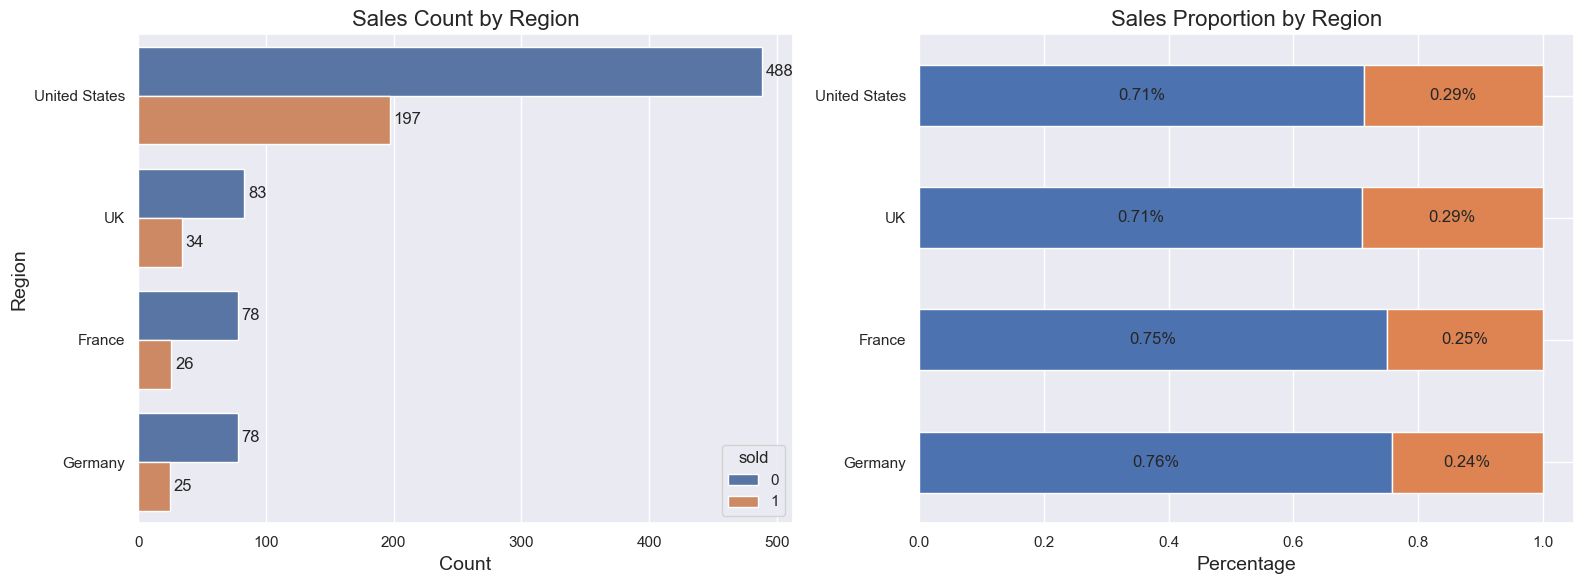

In [4]:
analyze_sales(df, 'region', hue='sold', save=False)

# Доля продаж по источникам & Количество пользователей с разбивкой на платящих/не платящих по источникам

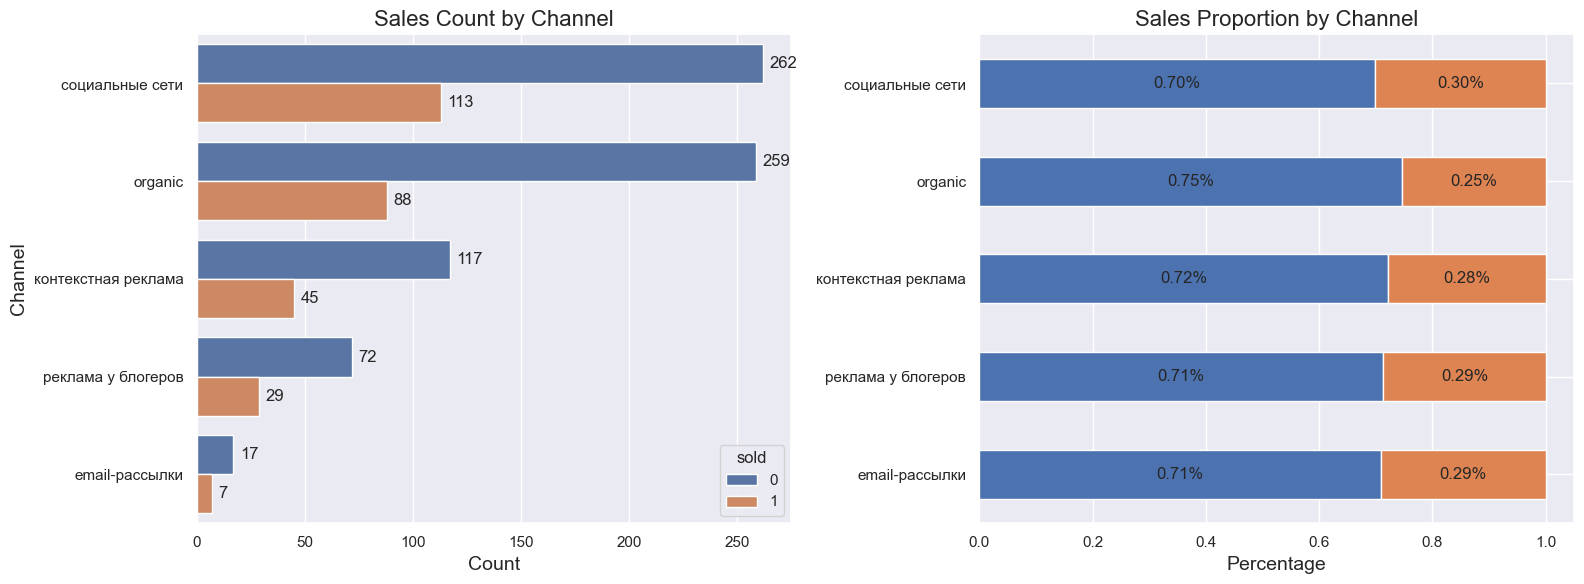

In [5]:
analyze_sales(df, 'channel', hue='sold', save=False)

# Доля продаж по устройствам &  Количество пользователей с разбивкой на платящих/не платящих по устройствам

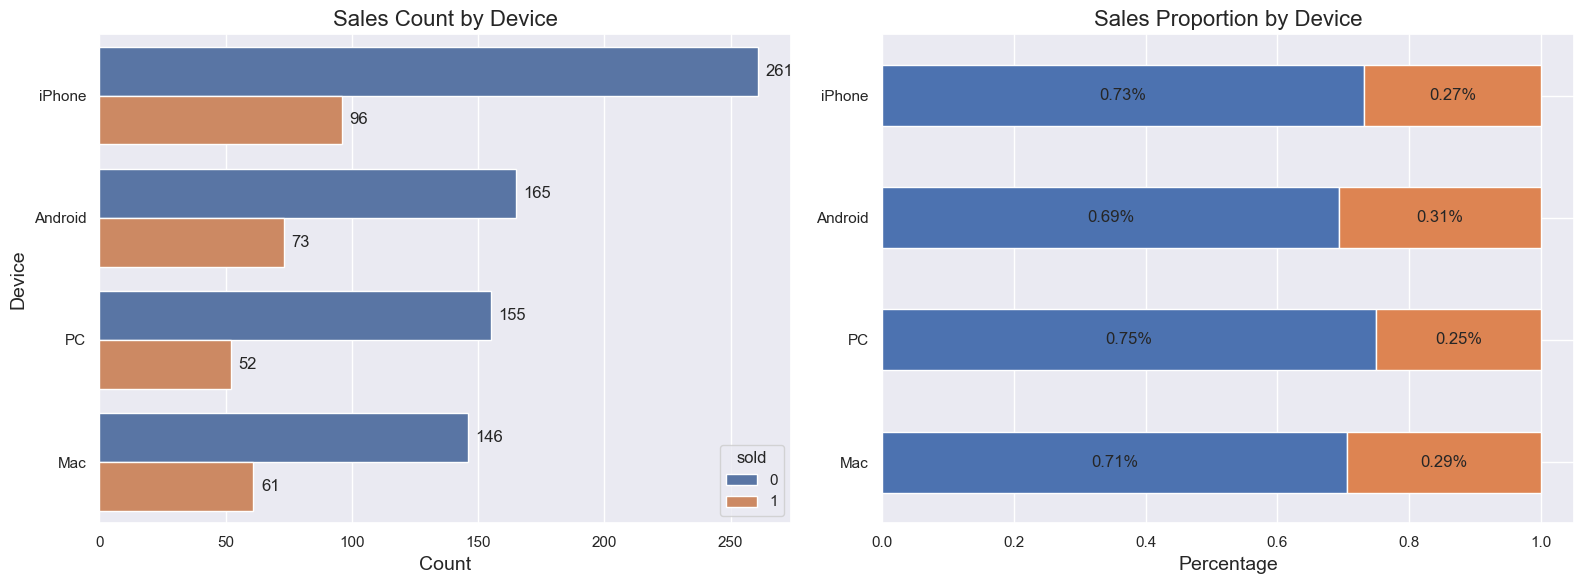

In [6]:
analyze_sales(df, 'device', hue='sold', save=False)

# Графики, показывающие есть ли сезонность в продажах по месяцам, дням недели, времени суток

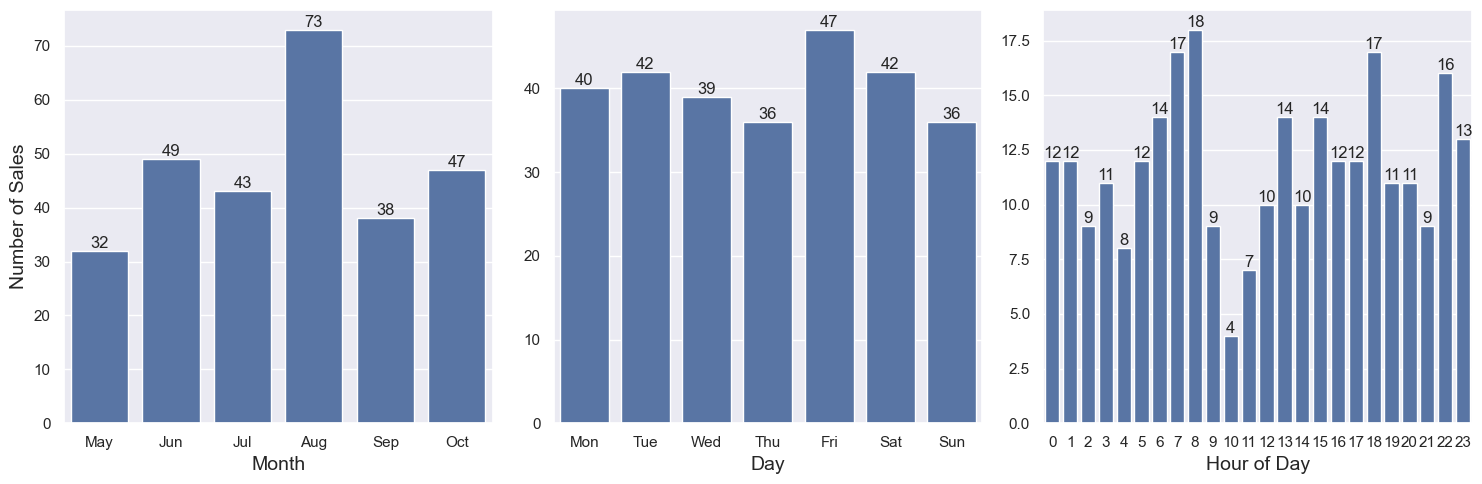

In [7]:
analyze_time_series(df, save=False)

# Диаграмма количества покупок по типу оплаты

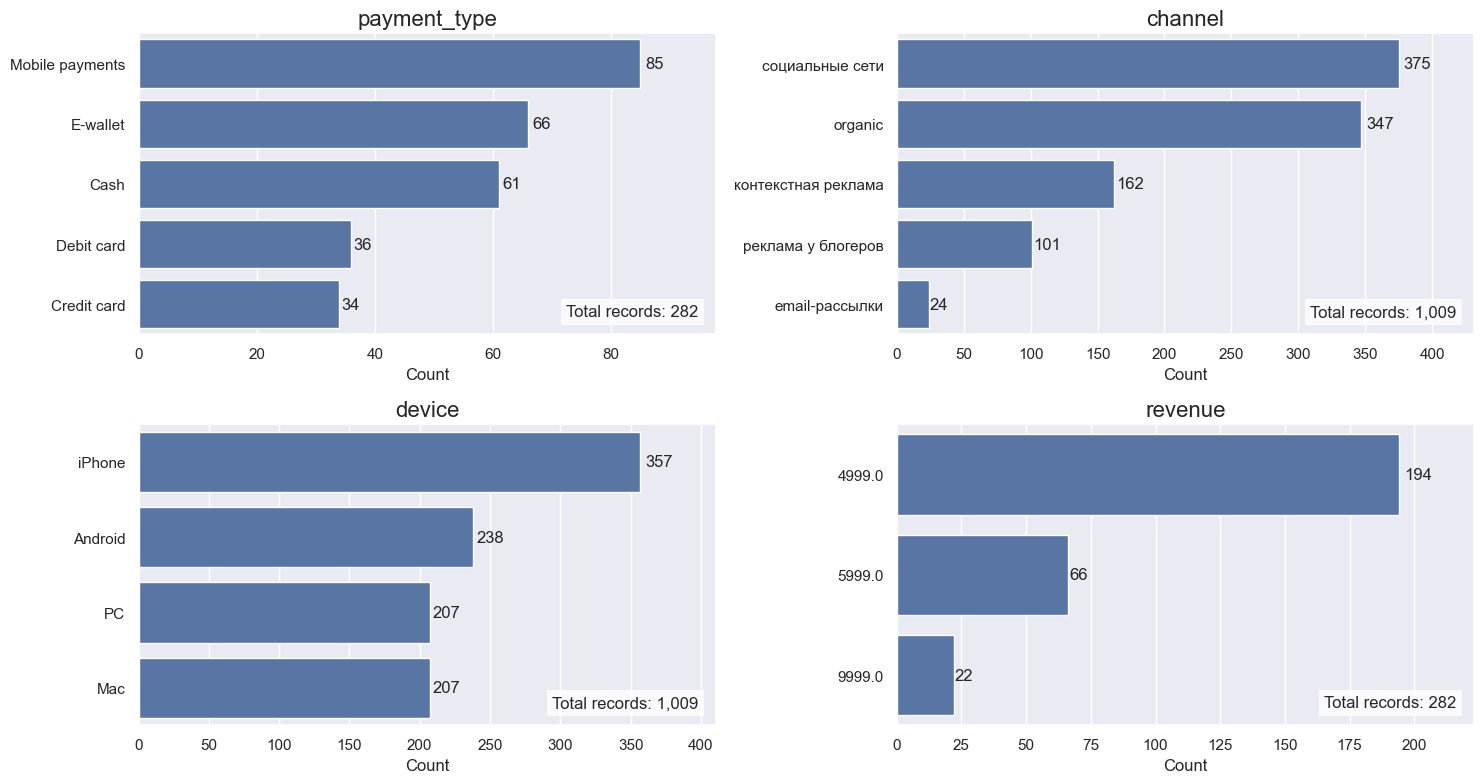

In [8]:
analyze_distribution(df, ['payment_type', 'channel', 'device', 'revenue'], normalize=False, save=False)